<a href="https://colab.research.google.com/github/laraAkg/Data-Science-Project/blob/main/Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Heavy-Tailed Distributions and Extreme Value Theory

## 0. Dependency Installation

This cell installs the external Python packages required for the evaluation notebook.

In [1]:
!pip install pyextremes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.5 MB/s eta 0:00:00


## 1. Colab / Drive Setup, Imports & Evaluation Configuration

This cell initializes the execution environment for the evaluation notebook.  
It loads all required libraries, detects whether the code is running in Google Colab, mounts Google Drive if needed, and defines the full project directory structure.  
In addition, it loads the metadata of the previously selected *best model* and configures global evaluation settings such as image size, random seeds, and device selection.

- **Library Imports**: Loads standard Python utilities, data processing libraries, TensorFlow/Keras, and scikit-learn metrics required for model evaluation.
- **Colab Detection (`IN_COLAB`)**: Automatically checks whether the notebook is running in Google Colab and mounts Google Drive if applicable.
- **`BASE_DIR` & Project Paths**: Defines a unified base directory and all subdirectories for datasets, plots, metadata, trained models, reports, evaluation outputs, and CSV uploads.
- **`BEST_MODEL_META`**: Loads the metadata JSON of the final best model selected during training (required for evaluation).
- **Directory Initialization**: Ensures that all required directories exist before evaluation starts.
- **`IMG_SIZE`**: Defines the fixed input image size used for loading and stacking plot images.
- **Best Model Calibration Parameters**:
  - **`t_opt_best`**: Optimal decision threshold for binary classification.
  - **`T_best`**: Temperature scaling factor used to calibrate model logits.
  - **`t_low_best`, `t_high_best`**: Thresholds defining the gray/uncertainty zone.
- **Reproducibility (`SEED`)**: Sets fixed random seeds for Python, NumPy, and TensorFlow to ensure consistent evaluation results.
- **Device Detection (`DEVICE`)**: Automatically selects GPU if available, otherwise falls back to CPU.
- **`DEBUG_MODE`**: Controls whether a reduced evaluation setup is used, consistent with the training notebook configuration.

In [2]:
import os, json, math, time, random, csv
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from io import BytesIO

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)

from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

DEFAULT_PROJECT_DIR = "MyDrive/Generated Data for Data science project"
BASE_DIR = Path("/content/drive") / DEFAULT_PROJECT_DIR if IN_COLAB else Path("./project_outputs")

DATA_DIR    = BASE_DIR / "datasets"
PLOTS_DIR   = BASE_DIR / "plots"
META_DIR    = BASE_DIR / "metadata"
MODELS_DIR  = BASE_DIR / "models_tf"
REPORTS_DIR = BASE_DIR / "reports"
REAL_DIR    = BASE_DIR / "real"
BEST_MODEL_PATH = MODELS_DIR / "best_model_keras.h5"
BEST_MODEL_META = REPORTS_DIR / "best_model_meta.json"
CSV_UPLOAD_DIR = BASE_DIR / "csv_upload"
EVAL_DIR       = REPORTS_DIR / "best_model_eval"

assert BEST_MODEL_META.exists(), f"Best model meta file fehlt: {BEST_MODEL_META}"
with open(BEST_MODEL_META, "r", encoding="utf-8") as f:
    best_meta = json.load(f)

for p in [DATA_DIR, PLOTS_DIR, META_DIR, MODELS_DIR, REPORTS_DIR, REAL_DIR, CSV_UPLOAD_DIR, EVAL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (128, 128)  # (H, W)

print("BASE_DIR:", BASE_DIR)
print("CSV_UPLOAD_DIR:", CSV_UPLOAD_DIR)
print("EVAL_DIR:", EVAL_DIR)

t_opt_best  = float(best_meta["t_opt"])
T_best      = float(best_meta.get("T", 1.0))
t_low_best  = float(best_meta.get("t_low", 0.30))
t_high_best = float(best_meta.get("t_high", 0.70))

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DEVICE = "GPU" if len(tf.config.list_physical_devices('GPU')) > 0 else "CPU"
BATCH_SIZE_DEFAULT = 32

DEBUG_MODE = True

print("TF device:", DEVICE)

Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/Generated Data for Data science project
CSV_UPLOAD_DIR: /content/drive/MyDrive/Generated Data for Data science project/csv_upload
EVAL_DIR: /content/drive/MyDrive/Generated Data for Data science project/reports/best_model_eval
TF device: GPU


## 2. Load Metadata & Build Samples Table (Including Augmentations)

This cell loads the dataset metadata generated during data creation and builds a unified samples table used for model evaluation.  
Each dataset is expanded into multiple samples by including the original plots as well as all available augmentations.  
Additionally, helper functions are defined to load plot images and construct TensorFlow datasets in the same way as in the training notebook.

- **`datasets_index.json`**: Metadata source containing dataset IDs, labels, and file paths to all generated plots.
- **`samples`**: A list of sample entries, where each entry corresponds to one dataset variant (original or augmentation) and its label.
- **`uniq_rows`**: A list of unique dataset IDs and labels, used for dataset-level evaluation and stratified splitting.
- **`load_gray_resized`**: Loads a plot image, converts it to grayscale, resizes it to the model input size, and normalizes pixel values.
- **`stack_zipf_qq_me`**: Stacks the Zipf, Q–Q, and Mean Excess plots into a single 3-channel image tensor.
- **`sample_to_example`**: Converts a sample row into an input tensor **X** and its corresponding label **y**.
- **`rows_for_ids`**: Filters the samples table by a given set of dataset IDs.
- **`make_tf_dataset`**: Builds a `tf.data.Dataset` with optional shuffling, batching, and prefetching for efficient evaluation.

In [3]:
INDEX_JSON = META_DIR / "datasets_index.json"
with open(INDEX_JSON, "r", encoding="utf-8") as f:
    records = json.load(f)

samples = []
uniq_rows = []
for r in records:
    ds_id = r["dataset_id"]
    label = int(r["heavy_tailed"])
    uniq_rows.append({"dataset_id": ds_id, "label": label})
    samples.append({
        "dataset_id": ds_id,
        "variant": "original",
        "paths": r["plots"]["original"],
        "label": label,
    })
    for aug_name, aug_paths in r["plots"]["aug"].items():
        samples.append({
            "dataset_id": ds_id,
            "variant": aug_name,
            "paths": aug_paths,
            "label": label,
        })

print("Unique dataset_ids:", len(uniq_rows))
print("Total samples (incl. augs):", len(samples))

def load_gray_resized(path: str | Path) -> np.ndarray:
    img = Image.open(path).convert("L")
    img = img.resize((IMG_SIZE[1], IMG_SIZE[0]))
    arr = np.asarray(img).astype("float32") / 255.0
    return arr

def stack_zipf_qq_me(paths_dict: dict) -> np.ndarray:
    z = load_gray_resized(paths_dict["zipf"])
    q = load_gray_resized(paths_dict["qq_exp"])
    m = load_gray_resized(paths_dict["me"])
    return np.stack([z, q, m], axis=-1)

def sample_to_example(row: dict) -> tuple[np.ndarray, np.float32]:
    x = stack_zipf_qq_me(row["paths"])
    y = np.float32(row["label"])
    return x, y

def rows_for_ids(id_array) -> list[dict]:
    s = set(id_array)
    return [row for row in samples if row["dataset_id"] in s]

def make_tf_dataset(rows: list[dict],
                    batch_size: int = BATCH_SIZE_DEFAULT,
                    shuffle: bool = False) -> tf.data.Dataset:
    xs, ys = [], []
    for r in rows:
        x, y = sample_to_example(r)
        xs.append(x)
        ys.append(y)
    xs = np.stack(xs, axis=0)
    ys = np.array(ys, dtype=np.float32)
    ds = tf.data.Dataset.from_tensor_slices((xs, ys))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(xs), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Unique dataset_ids: 600
Total samples (incl. augs): 2400


## 3. Cross-Validation Results Loading & Best Model Selection

This cell loads the cross-validation results generated during model training, aggregates validation metrics across folds, and identifies the best-performing model configuration.  
The logic is intentionally aligned with the training notebook to ensure consistency between model selection and evaluation.

- **`load_cv_results`**: Loads the cross-validation results CSV and converts relevant metric columns to numeric values for reliable comparison.
- **`best_row`**: Selects the best-performing row from a validation subset based on a primary metric (e.g. ROC-AUC) and a secondary tie-breaker metric.
- **`summarize_hparams`**: Aggregates validation metrics across folds for each hyperparameter configuration, computing mean and standard deviation.
- **`select_best_config`**: Identifies the hyperparameter configuration with the best average validation performance across folds.
- **`CV_CSV`**: Path to the cross-validation results file produced by the training notebook.
- **`df_val`**: Validation-only subset of the CV results, used for model selection.
- **`best_cfg_dict`**: Dictionary containing the hyperparameters of the best aggregated configuration.
- **`best_fold`**: Fold index corresponding to the best validation result within the selected configuration, used for CV split reconstruction.
- **`best_model_path`**: Path to the final retrained best model loaded from the metadata file.
- **Calibration Parameters**: Reports the temperature (`T_best`), optimal decision threshold, and gray-zone thresholds used for evaluation.

In [4]:
def load_cv_results(csv_path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df.dropna(how="all")
    for col in [
        "acc","f1","roc_auc","pr_auc","ece","abstain","acc_decided","threshold",
        "ds_acc","ds_f1","ds_roc_auc","ds_pr_auc",
        "T","t_low","t_high","target_precision"
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def best_row(df_val: pd.DataFrame,
             primary: str = "roc_auc",
             secondary: str = "f1",
             higher_is_better: dict | None = None) -> pd.Series:
    p, s = primary.lower(), secondary.lower()
    hib = {"roc_auc": True, "f1": True, "acc": True, "pr_auc": True, "ece": False}
    if higher_is_better:
        hib.update({k.lower(): v for k, v in higher_is_better.items()})
    if df_val.empty:
        raise ValueError("No validation rows found in CSV (split=='val').")

    def sort_key(row):
        pk = row.get(p, np.nan)
        sk = row.get(s, np.nan)
        pk = pk if hib.get(p, True) else -pk
        sk = sk if hib.get(s, True) else -sk
        return (np.nan_to_num(pk, nan=-np.inf), np.nan_to_num(sk, nan=-np.inf))

    best_idx = max(df_val.index, key=lambda i: sort_key(df_val.loc[i]))
    return df_val.loc[best_idx]


def summarize_hparams(df_val: pd.DataFrame,
                      primary: str = "roc_auc",
                      secondary: str = "f1") -> pd.DataFrame:
    cfg_cols = ["model","lr","l2","epochs","bs","dropout"]
    g = df_val.groupby(cfg_cols)

    rows = []
    for cfg, sub in g:
        row = dict(zip(cfg_cols, cfg))
        row["n_folds"] = sub["fold"].nunique()
        for col in [primary, secondary]:
            row[f"mean_{col}"] = sub[col].mean()
            row[f"std_{col}"]  = sub[col].std(ddof=0)
        rows.append(row)

    return pd.DataFrame(rows)


def select_best_config(hp_df: pd.DataFrame,
                       primary: str = "roc_auc",
                       secondary: str = "f1") -> pd.Series:
    p = f"mean_{primary}"
    s = f"mean_{secondary}"

    if hp_df.empty:
        raise ValueError("Hyperparameter summary is empty.")

    best_idx = max(
        hp_df.index,
        key=lambda i: (hp_df.loc[i, p], hp_df.loc[i, s])
    )
    return hp_df.loc[best_idx]

CV_CSV = REPORTS_DIR / "cv_results_tuned_dropout_keras.csv"
assert CV_CSV.exists(), f"CV-Results CSV not found: {CV_CSV}"

df_cv = load_cv_results(CV_CSV)
df_val = df_cv[df_cv["split"] == "val"].copy()
assert not df_val.empty, "No rows with split=='val' found in CV-CSV."

hp_summary = summarize_hparams(df_val, primary="roc_auc", secondary="f1")
assert not hp_summary.empty, "No hyperparameter configurations found in the validation results."

best_cfg = select_best_config(hp_summary, primary="roc_auc", secondary="f1")
if hasattr(best_cfg, "to_dict"):
    best_cfg_dict = best_cfg.to_dict()
else:
    best_cfg_dict = dict(best_cfg)

mask_cfg = (
    (df_val["model"]   == best_cfg_dict["model"]) &
    (df_val["lr"]      == best_cfg_dict["lr"]) &
    (df_val["l2"]      == best_cfg_dict["l2"]) &
    (df_val["epochs"]  == best_cfg_dict["epochs"]) &
    (df_val["bs"]      == best_cfg_dict["bs"]) &
    (df_val["dropout"] == best_cfg_dict["dropout"])
)
df_val_cfg = df_val[mask_cfg].copy()
assert not df_val_cfg.empty, "No rows found for the best hyperparameter configuration."

best = best_row(df_val_cfg, primary="roc_auc", secondary="f1")

best_fold       = int(best["fold"])
best_model_path = Path(best_meta["model_path"])
target_precision_best = float(best_meta.get("target_precision", np.nan))

print("=== Best model (validation-based, aggregated hyperparameter configuration) ===")
print(f"Fold (for CV-Split-Rekonstruction): {best_fold}")
print(f"Model: {best.get('model', 'unknown')}")
print(f"Path (final retrained model): {best_model_path}")
print(f"LR: {best.get('lr')}, L2: {best.get('l2')}, Epochs: {best.get('epochs')}, "
      f"Batch Size: {best.get('bs', 'NA')}, Dropout: {best.get('dropout', 'NA')}")
print(f"Val ROC-AUC (this Fold): {best.get('roc_auc'):.4f}, PR-AUC: {best.get('pr_auc'):.4f}, "
      f"Acc: {best.get('acc'):.4f}, F1: {best.get('f1'):.4f}")
print(f"T (Temperature, final model): {T_best:.3f}")
print(f"t_low: {t_low_best:.3f}, t_high: {t_high_best:.3f}, target_precision: {target_precision_best}")
print(f"CV mean ROC-AUC (best config): {best_meta.get('cv_mean_roc_auc', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_roc_auc', float('nan')):.4f}")
print(f"CV mean F1 (best config):      {best_meta.get('cv_mean_f1', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_f1', float('nan')):.4f}")


=== Best model (validation-based, aggregated hyperparameter configuration) ===
Fold (for CV-Split-Rekonstruction): 1
Model: baseline
Path (final retrained model): /content/drive/MyDrive/Generated Data for Data science project/models_tf/best_model_keras.h5
LR: 0.001, L2: 0.0, Epochs: 2, Batch Size: 16, Dropout: 0.0
Val ROC-AUC (this Fold): 0.7652, PR-AUC: 0.7634, Acc: 0.5200, F1: 0.6471
T (Temperature, final model): 1.000
t_low: 0.300, t_high: 0.700, target_precision: 0.9
CV mean ROC-AUC (best config): 0.7652 +/- 0.0000
CV mean F1 (best config):      0.6471 +/- 0.0000


## 4. Reconstruct Cross-Validation Splits & Evaluation Helpers

This cell reconstructs the exact cross-validation fold splits used during model training and defines small helper functions required for evaluation.  
By mirroring the training setup, it ensures that evaluation results are directly comparable to the original cross-validation metrics.

- **`uniq_ids`, `uniq_label`**: Arrays of unique dataset IDs and their corresponding labels, used for fold-based splitting.
- **`StratifiedKFold`**: Recreates the outer cross-validation splits with the same configuration (`n_splits`, `shuffle`, `SEED`) as in the training notebook.
- **`DEBUG_MODE`**: Controls whether a reduced number of folds is used, ensuring consistency with the training setup.
- **`best_fold`**: Selects the fold corresponding to the best validation result identified earlier.
- **Outer Split (`train_val_idx`, `test_idx`)**: Separates training/validation data from the held-out test data.
- **Inner Split (`inner_train_idx`, `val_idx`)**: Further splits the training/validation set into training and validation subsets.
- **`train_rows`, `val_rows`, `test_rows`**: Sample-level rows constructed from the reconstructed dataset ID splits.
- **`sigmoid`**: Numerically stable sigmoid function used to convert model logits into probabilities during evaluation.

In [5]:
uniq_ids   = np.array([r["dataset_id"] for r in uniq_rows])
uniq_label = np.array([r["label"] for r in uniq_rows])

if DEBUG_MODE:
    skf_outer = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)
else:
    skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

outer_splits = list(skf_outer.split(uniq_ids, uniq_label))
assert 1 <= best_fold <= len(outer_splits), "best_fold outside the number of outer splits."

train_val_idx, test_idx = outer_splits[best_fold - 1]
tv_ids = uniq_ids[train_val_idx]
tv_lab = uniq_label[train_val_idx]
test_ids = uniq_ids[test_idx]

skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_train_idx, val_idx = next(skf_inner.split(tv_ids, tv_lab))

train_ids = tv_ids[inner_train_idx]
val_ids   = tv_ids[val_idx]

train_rows = rows_for_ids(train_ids)
val_rows   = rows_for_ids(val_ids)
test_rows  = rows_for_ids(test_ids)

print(f"Fold {best_fold}:")
print("  Train uniq_ids:", len(np.unique(train_ids)))
print("  Val   uniq_ids:", len(np.unique(val_ids)))
print("  Test  uniq_ids:", len(np.unique(test_ids)))

def sigmoid(x: np.ndarray) -> np.ndarray:
    """Numerically stable sigmoid function for logits."""
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))


Fold 1:
  Train uniq_ids: 240
  Val   uniq_ids: 60
  Test  uniq_ids: 300


## 5. Performance Summary from Cross-Validation Results

This cell extracts and summarizes the key performance metrics for the selected best model from the cross-validation results generated during training.  
It creates a compact train/validation/test overview, prints the most important metrics, and generates simple bar charts for quick comparison across splits.

- **`CV_CSV`**: Path to the cross-validation results CSV produced by the training notebook.
- **`df_cv`**: Full CV results table loaded from the CSV file.
- **`orig_model_path`**: Attempts to retrieve the original fold model path stored in `best_meta` (falls back to `model_path` if missing).
- **`mask_best`**: Filters the CV results to the rows matching the selected `best_fold` and the model type stored in `best_meta`.
- **`df_best`**: Subset of CV rows corresponding to the best model for the selected fold.
- **`splits`**: Defines the evaluation splits shown in the summary (`train`, `val`, `test`).
- **`metric_cols`**: Metrics included in the summary table (`acc`, `f1`, `roc_auc`, `pr_auc`, `ece`).
- **`df_summary`**: Compact summary table with one row per split and the selected metrics.
- **Printed Overview**: Displays fold information, model type, and both the original training path and the final retrained model path used in evaluation.
- **CV vs Final Model Metrics**: Prints aggregated CV mean/std metrics from `best_meta` and compares them to the final retrained model’s validation metrics stored in the same metadata file.
- **`plot_metric_bar`**: Helper function that creates a simple bar chart (train/val/test) for a selected metric and saves it to `EVAL_DIR`.
- **`plot_metric_bar(..., "acc")`, `plot_metric_bar(..., "roc_auc")`**: Generates and saves bar plots for Accuracy and ROC-AUC across splits.

=== most important metrics for the best model ===
Fold: 1
Model: baseline
Original Model Path (Training): /content/drive/MyDrive/Generated Data for Data science project/models_tf/best_model_keras.h5
Saved Model Path (Evaluation): /content/drive/MyDrive/Generated Data for Data science project/models_tf/best_model_keras.h5



,split,acc,f1,roc_auc,pr_auc,ece
0,val,0.52,0.647059,0.765155,0.763373,0.208268
1,test,0.51,0.647482,0.743878,0.655211,0.208076


  val: acc=0.5200, f1=0.6471, roc_auc=0.7652, pr_auc=0.7634, ece=0.2083
 test: acc=0.5100, f1=0.6475, roc_auc=0.7439, pr_auc=0.6552, ece=0.2081

=== CV-Overview (aggregated hyperparameter configuration, from meta) ===
CV mean ROC-AUC: 0.7652 +/- 0.0000
CV mean F1:      0.6471 +/- 0.0000

=== Final validation split of the retrained model (from meta) ===
final acc:     0.2800
final f1:      0.4375
final roc_auc: 0.5893
final pr_auc:  0.4662
final ds_acc:  0.2800
final ds_f1:   0.4375
final ds_roc:  0.6508
final ds_pr:   0.5700


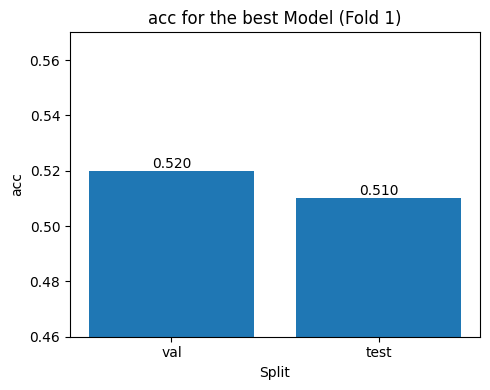

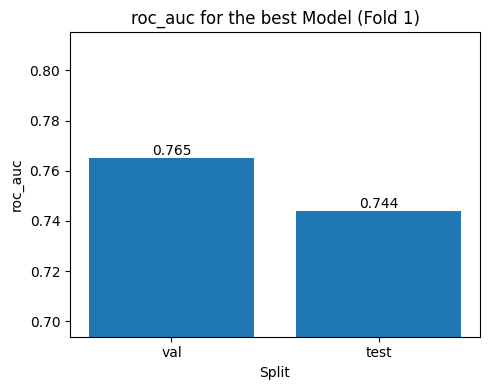

In [6]:
CV_CSV = REPORTS_DIR / "cv_results_tuned_dropout_keras.csv"
assert CV_CSV.exists(), f"CV-Results CSV not found: {CV_CSV}"

df_cv = pd.read_csv(CV_CSV)

orig_model_path = best_meta.get("original_model_path", None)
if orig_model_path is None:
    orig_model_path = best_meta.get("model_path")

mask_best = (
    (df_cv["split"].isin(["train", "val", "test"])) &
    (df_cv["fold"] == best_fold) &
    (df_cv["model"].astype(str) == best_meta.get("model"))
)

df_best = df_cv[mask_best].copy()
assert not df_best.empty, (
    "No matching rows found in CV-CSV.\n"
    f"fold={best_fold}, model={best_meta.get('model')}"
)

splits = ["train", "val", "test"]
metric_cols = ["acc", "f1", "roc_auc", "pr_auc", "ece"]

summary_rows = []
for split in splits:
    sub = df_best[df_best["split"] == split]
    if sub.empty:
        continue
    row = {"split": split}
    for m in metric_cols:
        if m in sub.columns:
            val = sub.iloc[0][m]
            try:
                row[m] = float(val)
            except (TypeError, ValueError):
                row[m] = np.nan
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)

print("=== most important metrics for the best model ===")
print(f"Fold: {best_fold}")
print(f"Model: {best_meta.get('model', 'unknown')}")
print(f"Original Model Path (Training): {orig_model_path}")
print(f"Saved Model Path (Evaluation): {best_model_path}\n")

display(df_summary)

for _, r in df_summary.iterrows():
    split = r["split"]
    parts = []
    for m in metric_cols:
        if m in r and pd.notna(r[m]):
            parts.append(f"{m}={r[m]:.4f}")
    print(f"{split:>5}: " + ", ".join(parts))

print("\n=== CV-Overview (aggregated hyperparameter configuration, from meta) ===")
print(f"CV mean ROC-AUC: {best_meta.get('cv_mean_roc_auc', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_roc_auc', float('nan')):.4f}")
print(f"CV mean F1:      {best_meta.get('cv_mean_f1', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_f1', float('nan')):.4f}")

print("\n=== Final validation split of the retrained model (from meta) ===")
print(f"final acc:     {best_meta.get('acc', float('nan')):.4f}")
print(f"final f1:      {best_meta.get('f1', float('nan')):.4f}")
print(f"final roc_auc: {best_meta.get('roc_auc', float('nan')):.4f}")
print(f"final pr_auc:  {best_meta.get('pr_auc', float('nan')):.4f}")
print(f"final ds_acc:  {best_meta.get('ds_acc', float('nan')):.4f}")
print(f"final ds_f1:   {best_meta.get('ds_f1', float('nan')):.4f}")
print(f"final ds_roc:  {best_meta.get('ds_roc_auc', float('nan')):.4f}")
print(f"final ds_pr:   {best_meta.get('ds_pr_auc', float('nan')):.4f}")

def plot_metric_bar(df_summary: pd.DataFrame,
                    metric: str,
                    save_path: Path) -> None:
    if metric not in df_summary.columns:
        print(f"Column '{metric}' not in df_summary, skipping Plot.")
        return

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar(df_summary["split"], df_summary[metric])
    ax.set_xlabel("Split")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} for the best Model (Fold {best_fold})")
    try:
        ymin = max(0.0, float(df_summary[metric].min()) - 0.05)
        ymax = min(1.0, float(df_summary[metric].max()) + 0.05)
        if ymin < ymax:
            ax.set_ylim(ymin, ymax)
    except Exception:
        pass

    for i, v in enumerate(df_summary[metric]):
        if pd.notna(v):
            ax.text(i, v, f"{v:.3f}", ha="center", va="bottom")

    fig.tight_layout()
    fig.savefig(save_path, dpi=160, bbox_inches="tight")
    plt.show()

plot_metric_bar(df_summary, "acc",     EVAL_DIR / "bar_accuracy_splits.png")
plot_metric_bar(df_summary, "roc_auc", EVAL_DIR / "bar_roc_auc_splits.png")


## 6. Grad-CAM Explainability on Test Samples

This cell adds model explainability using Grad-CAM.  
It loads the final best model, computes calibrated predictions on a smaller subset of the test split, selects representative examples (confident positive/negative and gray-zone), and generates Grad-CAM visualizations that highlight which plot regions influenced the model’s decision.

- **`find_last_conv_layer`**: Finds the last convolutional layer (`Conv2D` / `SeparableConv2D`) required as the target layer for Grad-CAM.
- **`make_gradcam_heatmap`**: Computes a Grad-CAM heatmap for a given input image by backpropagating gradients from the selected prediction target to the last convolutional feature maps.
- **`overlay_heatmap`**: Blends the Grad-CAM heatmap with the input image for easier visual interpretation.
- **`best_model`**: Loads the final retrained best model from `best_model_path` (stored in the metadata and used throughout evaluation).
- **`last_conv_name`**: Name of the last convolutional layer used as the Grad-CAM target.
- **`pick_indices_for_explainability`**: Selects example indices for explainability:
  - high-confidence positives (`p >= 0.8`)
  - high-confidence negatives (`p <= 0.2`)
  - gray-zone predictions (`t_low_best <= p <= t_high_best`)
- **`predict_rows_for_explainability`**: Runs inference only on a small subset of `test_rows` (limited by `max_per_class`) to keep Grad-CAM execution fast.
- **`sigmoid(logits / T_best)`**: Converts logits to calibrated probabilities using temperature scaling (`T_best`).
- **`explain_sample`**: Creates and saves multiple visual panels per selected sample:
  - input image + heatmap + overlay
  - channel-specific overlays (Zipf / QQ / ME)
  - mean heatmap intensity along the x-axis (importance profile)
- **Output Files (`EVAL_DIR`)**: Saves all Grad-CAM plots for the selected test examples into the evaluation output directory.

Load best model for Explainability...
Model loaded.
Last conv layer: conv2d_7

Calculate predictions for Explainability-Subset...
Explainability-Subset Size: 200 (100 pos, 100 neg)
7/7 ━━━━━━━━━━━━━━━━━━━━ 293s 33s/step
Explainability-Predictions ready.
Shapes: (200,) (200,)
Explainability-Indizes (Subset): {'high_neg': 100}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
/tmp/ipython-input-2267601980.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hm = cm.get_cmap("jet")(heatmap)[..., :3]


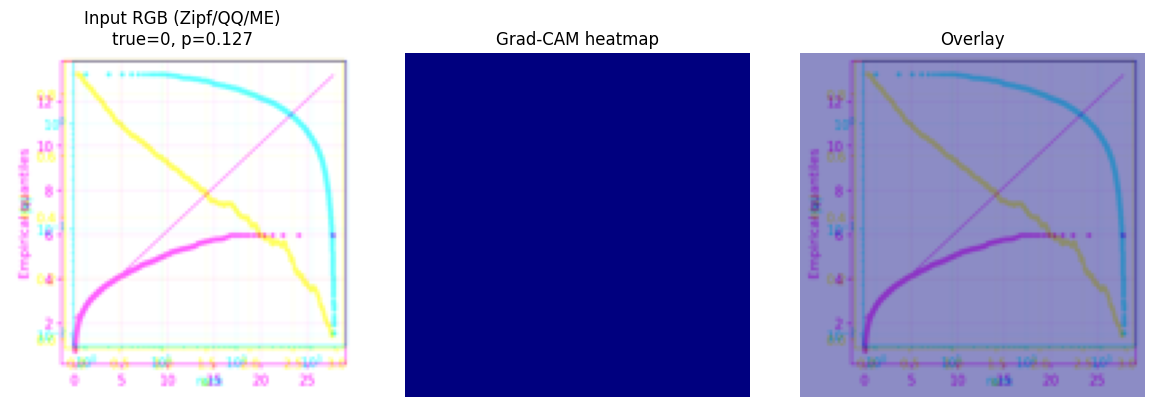

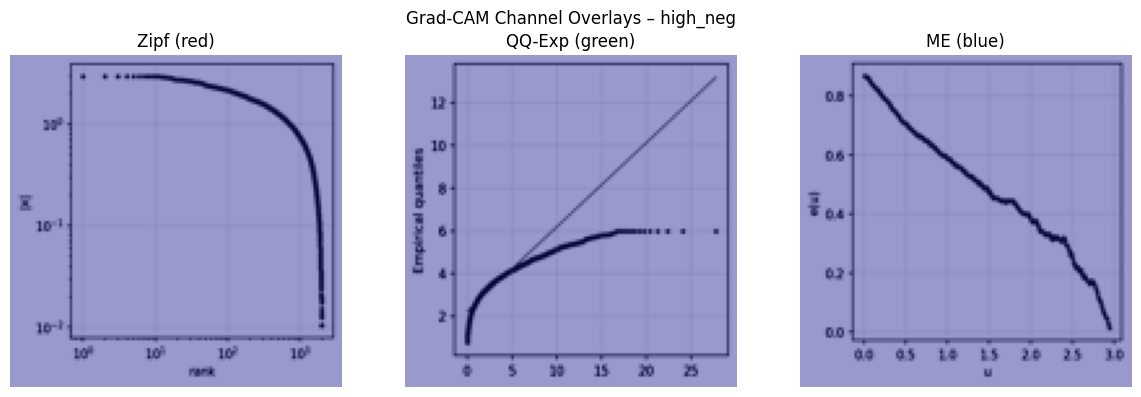

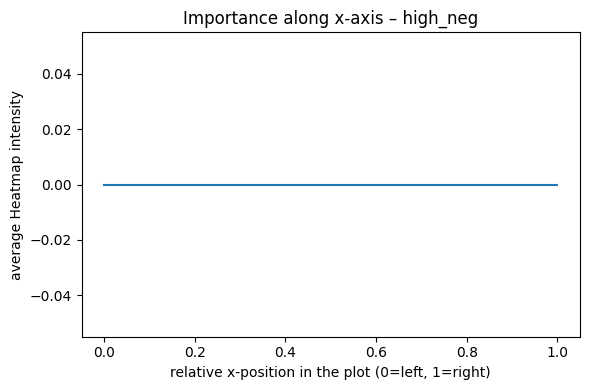

In [7]:
def find_last_conv_layer(model: keras.Model) -> str:
    for layer in reversed(model.layers):
        if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
            return layer.name
    raise ValueError("No Conv2D/SeparableConv2D layer found.")

def make_gradcam_heatmap(img_array: np.ndarray,
                         model: keras.Model,
                         last_conv_name: str,
                         pred_index: int | None = None) -> np.ndarray:
    grad_model = keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        target = predictions[:, pred_index]
    grads = tape.gradient(target, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    heatmap = np.array(
        Image.fromarray((heatmap*255).astype(np.uint8)).resize((IMG_SIZE[1], IMG_SIZE[0]))
    ) / 255.0
    return heatmap

def overlay_heatmap(rgb: np.ndarray,
                    heatmap: np.ndarray,
                    alpha: float = 0.45) -> np.ndarray:
    import matplotlib.cm as cm
    hm = cm.get_cmap("jet")(heatmap)[..., :3]
    out = (1 - alpha) * rgb + alpha * hm
    return np.clip(out, 0, 1)

print("Load best model for Explainability...")
assert best_model_path.exists(), f"Model file not found: {best_model_path}"
best_model = keras.models.load_model(best_model_path, compile=False)
print("Model loaded.")

last_conv_name = find_last_conv_layer(best_model)
print("Last conv layer:", last_conv_name)

def pick_indices_for_explainability(y: np.ndarray,
                                    p: np.ndarray,
                                    t_low: float,
                                    t_high: float):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).ravel()
    idx_pos = np.where((y == 1) & (p >= 0.8))[0]
    idx_neg = np.where((y == 0) & (p <= 0.2))[0]
    idx_gray = np.where((p >= t_low) & (p <= t_high))[0]

    choices = {}
    if len(idx_pos) > 0:
        choices["high_pos"] = int(idx_pos[0])
    if len(idx_neg) > 0:
        choices["high_neg"] = int(idx_neg[0])
    if len(idx_gray) > 0:
        choices["gray_zone"] = int(idx_gray[0])
    return choices

def predict_rows_for_explainability(all_rows,
                                    max_per_class: int = 100):

    rows_pos = [r for r in all_rows if r["label"] == 1]
    rows_neg = [r for r in all_rows if r["label"] == 0]

    rows_pos = rows_pos[:max_per_class]
    rows_neg = rows_neg[:max_per_class]

    subset_rows = rows_pos + rows_neg
    print(f"Explainability-Subset Size: {len(subset_rows)} "
          f"({len(rows_pos)} pos, {len(rows_neg)} neg)")

    ys = np.array([r["label"] for r in subset_rows], dtype=np.float32)

    def gen():
        for r in subset_rows:
            x, _ = sample_to_example(r)
            yield x

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=tf.TensorSpec(
            shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
            dtype=tf.float32
        )
    ).batch(BATCH_SIZE_DEFAULT).prefetch(tf.data.AUTOTUNE)

    logits = best_model.predict(ds, verbose=1).squeeze(-1)
    probs = sigmoid(logits / T_best)

    return subset_rows, ys, probs

print("\nCalculate predictions for Explainability-Subset...")
rows_expl, y_expl, p_expl = predict_rows_for_explainability(test_rows, max_per_class=100)

print("Explainability-Predictions ready.")
print("Shapes:", y_expl.shape, p_expl.shape)

explain_idx = pick_indices_for_explainability(y_expl, p_expl, t_low_best, t_high_best)
print("Explainability-Indizes (Subset):", explain_idx)

def explain_sample(row: dict,
                   prob: float,
                   true_label: int,
                   tag: str,
                   save_prefix: Path):
    x_np, _ = sample_to_example(row)  # (H,W,3)
    X = x_np[np.newaxis, ...]
    heatmap = make_gradcam_heatmap(X, best_model, last_conv_name)
    overlay = overlay_heatmap(x_np, heatmap, alpha=0.45)

    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(x_np)
    axs[0].set_title(f"Input RGB (Zipf/QQ/ME)\ntrue={true_label}, p={prob:.3f}")
    axs[0].axis("off")

    axs[1].imshow(heatmap, cmap="jet")
    axs[1].set_title("Grad-CAM heatmap")
    axs[1].axis("off")

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay")
    axs[2].axis("off")

    fig.tight_layout()
    out1 = save_prefix.parent / f"{save_prefix.name}_rgb_heatmap_overlay.png"
    fig.savefig(out1, dpi=160, bbox_inches="tight")
    plt.show()

    fig2, axs2 = plt.subplots(1, 3, figsize=(12,4))
    channel_names = ["Zipf (red)", "QQ-Exp (green)", "ME (blue)"]
    for c in range(3):
        img_c = x_np[..., c]
        axs2[c].imshow(img_c, cmap="gray")
        axs2[c].imshow(heatmap, cmap="jet", alpha=0.4)
        axs2[c].set_title(f"{channel_names[c]}")
        axs2[c].axis("off")
    fig2.suptitle(f"Grad-CAM Channel Overlays – {tag}")
    fig2.tight_layout()
    out2 = save_prefix.parent / f"{save_prefix.name}_channels_overlay.png"
    fig2.savefig(out2, dpi=160, bbox_inches="tight")
    plt.show()

    importance_x = heatmap.mean(axis=0)
    xs = np.linspace(0, 1, len(importance_x))
    fig3, ax3 = plt.subplots(figsize=(6,4))
    ax3.plot(xs, importance_x)
    ax3.set_xlabel("relative x-position in the plot (0=left, 1=right)")
    ax3.set_ylabel("average Heatmap intensity")
    ax3.set_title(f"Importance along x-axis – {tag}")
    fig3.tight_layout()
    out3 = save_prefix.parent / f"{save_prefix.name}_importance_x.png"
    fig3.savefig(out3, dpi=160, bbox_inches="tight")
    plt.show()

for tag, idx in explain_idx.items():
    row = rows_expl[idx]
    prob = float(p_expl[idx])
    true_label = int(y_expl[idx])
    save_prefix = EVAL_DIR / f"gradcam_test_{tag}"
    explain_sample(row, prob, true_label, tag, save_prefix)


## 7. Optional: Preparing and Uploading Real-World Time Series for Evaluation

This cell provides optional helper utilities to integrate **real-world time series data** into the existing evaluation pipeline.  
It allows external data (e.g. extracted via *pyextremes*) to be converted into a compatible CSV format so that the trained model can automatically evaluate it in later steps (7.2 / 7.3).

- **`save_series_for_eval`**: Saves a 1D numerical series as a CSV file in `CSV_UPLOAD_DIR`, matching the expected upload format.
- **`CSV_UPLOAD_DIR`**: Central directory where all uploaded or generated CSV files are stored for evaluation.
- **`pyextremes.EVA` (optional)**: If available, used to extract extreme values from real-world time series using Extreme Value Analysis (EVA).
- **Automatic fallback dataset**:
  - If `REAL_DIR` is empty, the official *pyextremes* example dataset (`battery_wl.csv`) is automatically downloaded.
- **Column & index inference helpers**:
  - **`_infer_real_value_column`**: Selects the most suitable numeric value column from a CSV file.
  - **`_infer_time_index`**: Attempts to infer a meaningful time or date index for the series.
- **`prepare_pyextremes_from_real_dir`**:
  - Loads all CSV files from `REAL_DIR`.
  - Extracts extremes using *Block Maxima (BM)* or *POT* methods.
  - Saves the extracted extreme values as new CSVs into `CSV_UPLOAD_DIR`.
- **Automatic execution**:
  - The helper is intentionally executed **here**, ensuring that all required CSVs exist before the downstream evaluation steps run.

This setup makes it possible to seamlessly evaluate the trained model on **external, real-world extreme value data** without modifying the core training or evaluation logic.

In [8]:
def save_series_for_eval(x,
                         filename: str,
                         column_name: str = "value"):
    x = np.asarray(x, dtype="float32").ravel()
    df = pd.DataFrame({column_name: x})
    CSV_UPLOAD_DIR.mkdir(parents=True, exist_ok=True)
    out_path = CSV_UPLOAD_DIR / f"{filename}.csv"
    df.to_csv(out_path, index=False)
    print(f"[INFO] Saved {len(x)} points to: {out_path}")


try:
    from pyextremes import EVA
except ImportError:
    EVA = None
    print("[WARN] pyextremes ist not installed. "
          "Install it e.g. with pip install pyextremes and re-run this cell")

PYEXTREMES_EXAMPLE_URL = (
    "https://raw.githubusercontent.com/georgebv/pyextremes-notebooks/master/data/battery_wl.csv"
)

def _infer_real_value_column(df: pd.DataFrame) -> str:
    if "value" in df.columns:
        return "value"
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError("No numeric column found in REAL-CSV.")
    return num_cols[0]

def _infer_time_index(df: pd.DataFrame) -> pd.Index:
    candidates = [c for c in df.columns
                  if ("date" in c.lower()) or ("time" in c.lower())]
    for c in candidates:
        try:
            idx = pd.to_datetime(df[c], errors="coerce")
            if idx.notna().sum() >= len(df) * 0.5:
                return idx
        except Exception:
            continue
    return pd.RangeIndex(start=0, stop=len(df), step=1)

def _ensure_real_csvs_from_pyextremes_example() -> list[Path]:
    real_paths = sorted(REAL_DIR.glob("*.csv"))
    if real_paths:
        return real_paths

    print(f"[INFO] REAL_DIR is empty – download example dataset from pyextremes:")
    print(f"       {PYEXTREMES_EXAMPLE_URL}")

    try:
        import requests
    except ImportError:
        print("[WARN] 'requests' ist nicht installiert, kann Beispiel-Datensatz nicht laden.")
        return real_paths

    try:
        resp = requests.get(PYEXTREMES_EXAMPLE_URL, timeout=30)
        resp.raise_for_status()
    except Exception as e:
        print(f"[WARN] 'requests' is not installed, cannot load example dataset: {e}")
        return real_paths

    REAL_DIR.mkdir(parents=True, exist_ok=True)
    out_path = REAL_DIR / "battery_wl_pyextremes.csv"
    with open(out_path, "wb") as f:
        f.write(resp.content)

    print(f"[INFO] Example dataset saved to: {out_path}")
    return sorted(REAL_DIR.glob("*.csv"))

def prepare_pyextremes_from_real_dir(method: str = "BM"):
    if EVA is None:
        print("[WARN] EVA class not available (pyextremes missing).")
        return

    real_paths = _ensure_real_csvs_from_pyextremes_example()

    if not real_paths:
        print(f"[INFO] No CSV files in {REAL_DIR} found.")
        return

    print(f"[INFO] find {len(real_paths)} REAL-CSV-file(s) in {REAL_DIR}")

    for path in real_paths:
        print(f"\n[INFO] Process REAL-CSV: {path.name}")
        df = pd.read_csv(path)

        try:
            val_col = _infer_real_value_column(df)
        except ValueError as e:
            print(f"[WARN] Skip {path.name}: {e}")
            continue

        idx = _infer_time_index(df)
        series = pd.Series(df[val_col].values, index=idx, name=val_col)

        try:
            eva = EVA(data=series)
            eva.get_extremes(method=method, errors="coerce")
        except Exception as e:
            print(f"[WARN] pyextremes EVA failed for {path.name}: {e}")
            continue


        if eva.extremes is None or len(eva.extremes) == 0:
            print(f"[WARN] No extreme values for {path.name} found.")
            continue

        extremes_obj = eva.extremes

        if isinstance(extremes_obj, pd.Series):
            extremes_values = extremes_obj.values

        else:
            extremes_df = extremes_obj

            if "values" in extremes_df.columns:
                extremes_values = extremes_df["values"].values
            else:
                num_cols_ext = extremes_df.select_dtypes(include=[np.number]).columns
                if len(num_cols_ext) == 0:
                    print(
                        f"[WARN] No numeric column in eva.extremes for {path.name}, "
                        "skipping."
                    )
                    continue
                col_ext = num_cols_ext[0]
                extremes_values = extremes_df[col_ext].values


        if len(extremes_values) == 0:
            print(f"[WARN] Extreme value series empty for {path.name}, skipping.")
            continue

        upload_name = f"{path.stem}_extremes_{method.lower()}"
        save_series_for_eval(extremes_values, filename=upload_name, column_name="value")

    print("\n[INFO] Preparation via pyextremes completed. "
          "The generated extreme value CSV files are now in CSV_UPLOAD_DIR "
          "and are automatically evaluated by the best model in 7.2/7.3.")

prepare_pyextremes_from_real_dir(method="BM")

[INFO] find 1 REAL-CSV-file(s) in /content/drive/MyDrive/Generated Data for Data science project/real

[INFO] Process REAL-CSV: battery_wl_pyextremes.csv


/usr/local/lib/python3.12/dist-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 4 blocks contained no data
  warnings.warn(


[INFO] Saved 100 points to: /content/drive/MyDrive/Generated Data for Data science project/csv_upload/battery_wl_pyextremes_extremes_bm.csv

[INFO] Preparation via pyextremes completed. The generated extreme value CSV files are now in CSV_UPLOAD_DIR and are automatically evaluated by the best model in 7.2/7.3.


### 7.1 Plot Functions for Real-Series Evaluation (Zipf / QQ-Exp / ME)

This cell defines plotting and image-conversion utilities for **real-world time series**, ensuring that they are transformed into CNN inputs **identical to those used during synthetic data generation and training**.  
By reusing the same plotting logic, layout, and preprocessing steps, it guarantees full consistency between training data and real-data evaluation.

- **Matplotlib configuration (`DPI`, `FIGSIZE`)**: Matches the exact rendering settings from the data-generation notebook to avoid layout drift.
- **`fig_to_gray_array`**: Converts a Matplotlib figure into a grayscale image array scaled to `IMG_SIZE`; intentionally avoids `bbox_inches="tight"` to preserve layout.
- **Sanitization & sampling utilities**:
  - **`_sanitize`**: Removes NaNs and infinite values from the input series.
  - **`_downsample`**: Randomly downsamples large series using an explicit RNG to control randomness.
  - **`_clamp_by_percentile`**: Clips extreme values to stabilize plots (used for Mean Excess).
- **Figure generators (display-level)**:
  - **`make_zipf_fig`**: Zipf plot of sorted absolute values (log–log scale).
  - **`make_me_fig`**: Mean Excess plot for tail diagnostics.
  - **`make_qq_exp_fig`**: QQ plot against an exponential distribution (Exp(1)).
- **Array builders (CNN inputs)**:
  - **`plot_zipf_array`**, **`plot_me_array`**, **`plot_qq_norm_array`**: Convert the corresponding figures into grayscale image arrays.
  - **`build_rgb_from_series`**: Stacks the three plots into a 3-channel image tensor.
    - Channel order is fixed as **[Zipf, QQ-Exp, ME]**, exactly matching the training setup.
    - RNG usage and call order are kept identical to ensure reproducible behavior.

This block is critical for making sure that **real data is evaluated under the same visual and statistical representation** as the synthetic training data, enabling fair and meaningful model predictions.

In [9]:
DPI     = 150
FIGSIZE = (4.0, 4.0)

plt.rcParams["figure.dpi"]    = DPI
plt.rcParams["savefig.dpi"]   = DPI
plt.rcParams["figure.figsize"]= FIGSIZE


def fig_to_gray_array(fig, size=IMG_SIZE) -> np.ndarray:
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=DPI)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("L").resize((size[1], size[0]))
    return (np.asarray(img).astype("float32") / 255.0)


def _sanitize(x):
    x = np.asarray(x).ravel()
    return x[~np.isnan(x) & ~np.isinf(x)]

def _downsample(x, max_points=50_000, rng=None):
    n = x.shape[0]
    if n <= max_points:
        return x
    if rng is None:
        rng = np.random.default_rng()
    idx = rng.choice(n, size=max_points, replace=False)
    return x[idx]

def _clamp_by_percentile(x, pct=99.5):
    lo = np.nanpercentile(x, 100 - pct)
    hi = np.nanpercentile(x, pct)
    if not np.isfinite(lo): lo = np.nanmin(x)
    if not np.isfinite(hi): hi = np.nanmax(x)
    x = np.clip(x, lo, hi)
    return x, (lo, hi)


def make_zipf_fig(x: np.ndarray, rng=None):
    x = _sanitize(np.abs(x))
    x = _downsample(x, rng=rng)
    x = np.sort(x)[::-1]
    ranks = np.arange(1, x.size + 1)

    fig, ax = plt.subplots()
    ax.loglog(ranks, x, marker=".", linewidth=0)
    ax.set_xlabel("rank")
    ax.set_ylabel("|x| (sorted)")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig

def make_me_fig(x: np.ndarray, n_bins: int = 200, rng=None):
    x = _sanitize(np.abs(x))
    x = _downsample(x, rng=rng)
    x, (lo, hi) = _clamp_by_percentile(x, 99.5)
    xs = np.sort(x)

    us = np.linspace(lo, hi, n_bins)
    e_vals = []
    for u in us:
        exceed = xs[xs > u]
        e_vals.append(np.mean(exceed - u) if exceed.size else np.nan)

    fig, ax = plt.subplots()
    ax.plot(us, e_vals, marker=".", linewidth=1)
    ax.set_xlabel("u")
    ax.set_ylabel("e(u)")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig

def make_qq_exp_fig(x: np.ndarray, rng=None):
    x = _sanitize(np.abs(x))
    x = _downsample(x, rng=rng)
    x = np.sort(x)
    n = x.size

    fig, ax = plt.subplots()
    if n == 0:
        ax.set_title("Empty sample")
    else:
        p = (np.arange(1, n + 1) - 0.5) / n
        q_theory = -np.log1p(-p)
        ax.plot(q_theory, x, marker=".", linewidth=0)
        ax.set_xlabel("Exp(1) quantiles")
        ax.set_ylabel("Sample |x| quantiles")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig


def plot_zipf_array(x: np.ndarray, rng=None) -> np.ndarray:
    fig = make_zipf_fig(x, rng=rng)
    return fig_to_gray_array(fig, size=IMG_SIZE)

def plot_me_array(x: np.ndarray, n_pts: int = 200, rng=None) -> np.ndarray:
    fig = make_me_fig(x, n_bins=n_pts, rng=rng)
    return fig_to_gray_array(fig, size=IMG_SIZE)

def plot_qq_norm_array(x: np.ndarray, rng=None) -> np.ndarray:
    fig = make_qq_exp_fig(x, rng=rng)
    return fig_to_gray_array(fig, size=IMG_SIZE)

def build_rgb_from_series(x: np.ndarray, rng=None) -> np.ndarray:
    z = plot_zipf_array(x, rng=rng)
    m = plot_me_array(x, rng=rng)
    q = plot_qq_norm_array(x, rng=rng)

    return np.stack([z, q, m], axis=-1)

### 7.2 Load Upload CSVs & Build CNN Input Batches

This cell reads all uploaded CSV files from `CSV_UPLOAD_DIR`, extracts the numeric series values, and converts each series into the same 3-channel CNN input representation used during training (Zipf / QQ-Exp / ME).  
It also visualizes the generated plots per file to make the model input transparent and reproducible.

- **`UPLOAD_COLUMN_DEFAULT`**: Default column name expected in upload CSVs (`"value"`).
- **`infer_upload_column`**: Selects the numeric column to use for evaluation:
  - prefers `UPLOAD_COLUMN_DEFAULT` if available
  - otherwise falls back to the first numeric column in the CSV
- **`upload_paths`**: Collects all CSV files in `CSV_UPLOAD_DIR`, excluding previously generated prediction outputs.
- **Deterministic RNG per file (`seed_series`, `rng_series`)**: Ensures downsampling and plotting behavior is reproducible for each uploaded file across runs.
- **`build_rgb_from_series`**: Converts a real numeric series into a 3-channel image tensor (Zipf, QQ-Exp, ME) matching the training input format.
- **Visualization (`make_zipf_fig`, `make_me_fig`, `make_qq_exp_fig`)**: Displays the three diagnostic plots for each uploaded series so users can verify what the model “sees”.
- **`rgbs` / `X_upload`**: Collects all generated RGB tensors and stacks them into a single batch (`X_upload`) ready for model inference.
- **`meta_rows`**: Stores per-file metadata (file name, chosen column, number of points) for later reporting and prediction export.

Uploaded CSV files found: 1


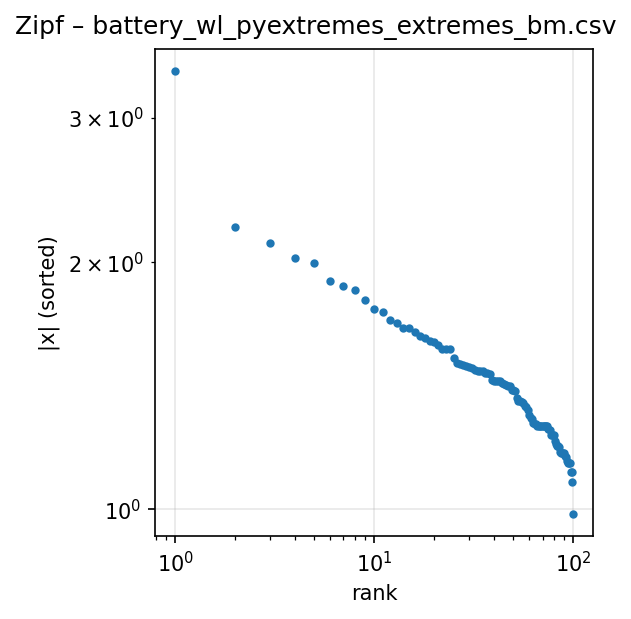

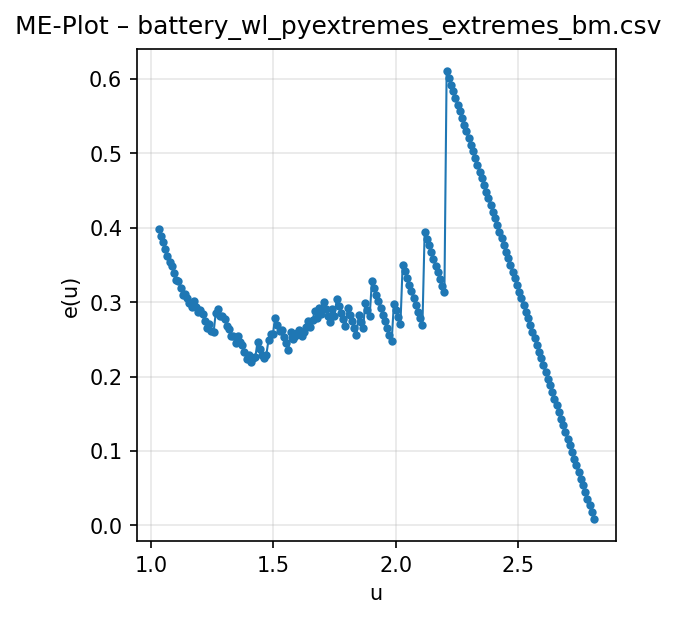

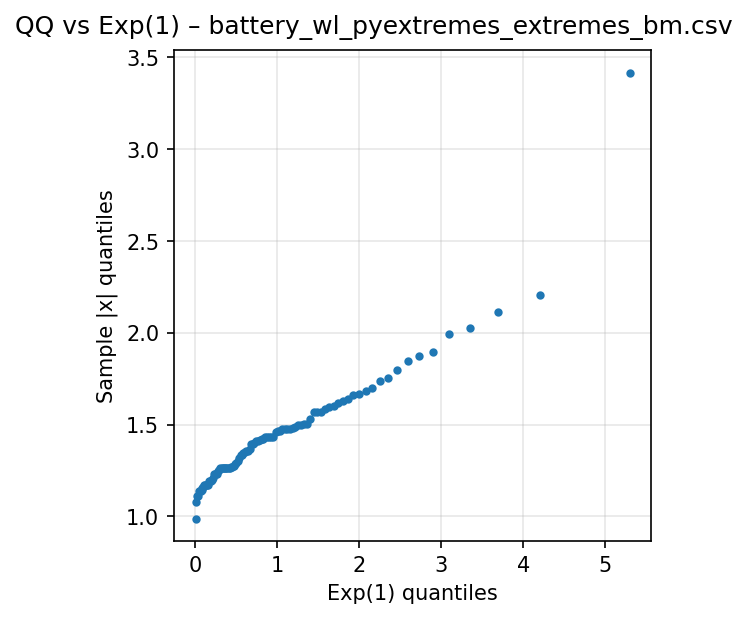

Upload-Batch-Shape: (1, 128, 128, 3)


In [10]:
UPLOAD_COLUMN_DEFAULT = "value"

def infer_upload_column(df: pd.DataFrame,
                        default: str = UPLOAD_COLUMN_DEFAULT) -> str:
    if default in df.columns:
        return default
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError("CSV contains no numeric column.")
    return num_cols[0]

upload_paths = sorted([
    p for p in CSV_UPLOAD_DIR.glob("*.csv")
    if not p.name.lower().startswith("predictions_")
])
print(f"Uploaded CSV files found: {len(upload_paths)}")

rgbs = []
meta_rows = []

for path in upload_paths:
    df = pd.read_csv(path)
    try:
        col = infer_upload_column(df)
    except ValueError as e:
        print(f"[WARN] Skipping {path.name}: {e}")
        continue
    x_series = df[col].values.astype("float32")
    if len(x_series) == 0:
        print(f"[WARN] Skipping {path.name}: Column {col} is empty.")
        continue

    seed_series = (SEED + (abs(hash(path.name)) % (2**31 - 1)))
    rng_series = np.random.default_rng(seed_series)

    rgb = build_rgb_from_series(x_series, rng=rng_series)

    rng_vis = np.random.default_rng(seed_series)

    fig_z = make_zipf_fig(x_series, rng=rng_vis)
    fig_m = make_me_fig(x_series, rng=rng_vis)
    fig_q = make_qq_exp_fig(x_series, rng=rng_vis)


    fig_z.suptitle(f"Zipf – {path.name}", y=1.02)
    fig_q.suptitle(f"QQ vs Exp(1) – {path.name}", y=1.02)
    fig_m.suptitle(f"ME-Plot – {path.name}", y=1.02)

    plt.show(fig_z)
    plt.show(fig_q)
    plt.show(fig_m)


    rgbs.append(rgb)
    meta_rows.append({
        "file_name": path.name,
        "column_used": col,
        "n_points": len(x_series),
    })

if rgbs:
    X_upload = np.stack(rgbs, axis=0)
    print("Upload-Batch-Shape:", X_upload.shape)
else:
    X_upload = None
    print("No valid upload CSV files found.")

### 7.3 Predict Heavy-Tail Probabilities on Uploaded Data

This cell runs inference on the uploaded real-series batch (`X_upload`) using the final best model and produces calibrated probability predictions.  
It applies multiple decision rules (fixed threshold, optimal threshold, and gray-zone detection), exports the results as a CSV file, and generates a probability histogram for a quick overview.

- **`best_model.predict`**: Computes raw model outputs (logits) for each uploaded series representation.
- **`sigmoid(logits_upload / T_best)`**: Converts logits to calibrated probabilities using temperature scaling (`T_best`).
- **`probs_upload`**: Predicted probability that the uploaded series is heavy-tailed.
- **Decision outputs**:
  - **`pred_0_5`**: Binary prediction using a fixed threshold of `0.5`.
  - **`pred_topt`**: Binary prediction using the optimal threshold from training (`t_opt_best`).
  - **`in_gray`**: Flags predictions within the uncertainty range (`t_low_best` to `t_high_best`).
- **`df_pred`**: Output table combining file metadata (`meta_rows`) with probabilities and classification decisions.
- **`predictions_best_model.csv`**: Saves the prediction table to `CSV_UPLOAD_DIR` for easy download and further analysis.
- **Histogram Export**: Creates and saves `hist_probs_uploads.png` in `EVAL_DIR` to visualize the distribution of predicted probabilities across all uploads.

,file_name,column_used,n_points,prob_heavy_tail,pred_0_5,pred_t_opt,in_gray_zone
0,battery_wl_pyextremes_extremes_bm.csv,value,100,0.126531,0,1,False


Predictions saved to: /content/drive/MyDrive/Generated Data for Data science project/csv_upload/predictions_best_model.csv


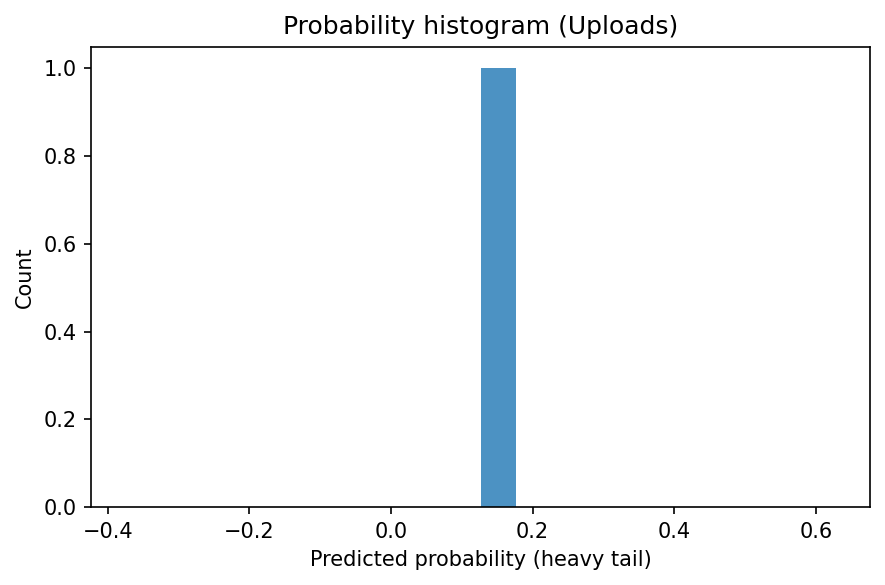

In [11]:
if X_upload is not None:
    logits_upload = best_model.predict(X_upload, batch_size=1, verbose=0).squeeze(-1)
    probs_upload  = sigmoid(logits_upload / T_best)

    pred_0_5  = (probs_upload >= 0.5).astype(int)
    pred_topt = (probs_upload >= t_opt_best).astype(int)
    in_gray   = (probs_upload >= t_low_best) & (probs_upload <= t_high_best)

    df_pred = pd.DataFrame(meta_rows)
    df_pred["prob_heavy_tail"] = probs_upload
    df_pred["pred_0_5"]        = pred_0_5
    df_pred["pred_t_opt"]      = pred_topt
    df_pred["in_gray_zone"]    = in_gray

    display(df_pred)

    out_csv = CSV_UPLOAD_DIR / "predictions_best_model.csv"
    df_pred.to_csv(out_csv, index=False)
    print("Predictions saved to:", out_csv)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(probs_upload, bins=20, alpha=0.8)
    ax.set_xlabel("Predicted probability (heavy tail)")
    ax.set_ylabel("Count")
    ax.set_title("Probability histogram (Uploads)")
    fig.tight_layout()
    fig.savefig(EVAL_DIR / "hist_probs_uploads.png", dpi=160, bbox_inches="tight")
    plt.show()

else:
    print("No upload data available for predictions.")